# SARIMA(p,d,q)(P,D,Q)m
# Seasonal Autoregressive Integrated Moving Averages
We have finally reached one of the most fascinating aspects of time series analysis: seasonality.

Where ARIMA accepts the parameters $(p,d,q)$, SARIMA accepts an <em>additional</em> set of parameters $(P,D,Q)m$ that specifically describe the seasonal components of the model. Here $P$, $D$ and $Q$ represent the seasonal regression, differencing and moving average coefficients, and $m$ represents the number of data points (rows) in each seasonal cycle.

<strong>NOTE:</strong> The statsmodels implementation of SARIMA is called SARIMAX. The “X” added to the name means that the function also supports <em>exogenous</em> regressor variables. We'll cover these in the next section.


<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html'>sarimax.SARIMAX</a></strong><font color=black>(endog[, exog, order, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.var_model.VARResults.html'>sarimax.SARIMAXResults</a></strong><font color=black>(model, params, …[, …])</font>&nbsp;&nbsp;Class to hold results from fitting a SARIMAX model.</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://www.statsmodels.org/stable/statespace.html'>Statsmodels Tutorial:</a></strong>&nbsp;&nbsp;<font color=black>Time Series Analysis by State Space Methods</font></div>

In [64]:
!pip install pmdarima

In [75]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_excel('TimeSeries.xlsx', parse_dates=['Date'])
df.head()

,Date,Transaction,Count
0,2016-01-01,00:00:00,2093576
1,2016-02-01,00:00:00,2397260
2,2016-03-01,00:00:00,2173039
3,2016-04-01,00:00:00,2051240
4,2016-05-01,00:00:00,1954117


In [76]:
df.drop('Transaction',axis=1, inplace=True)

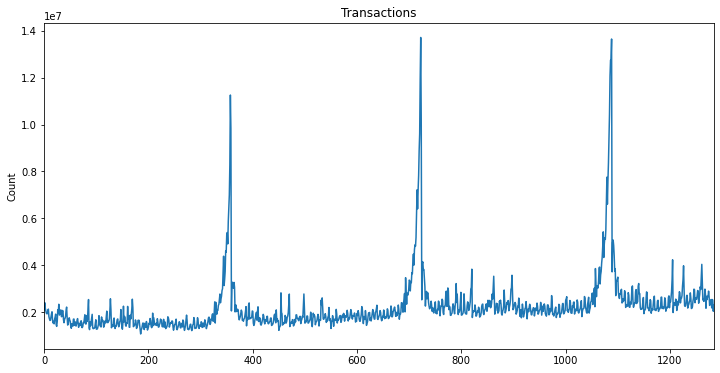

In [77]:
title = 'Transactions'
ylabel='Count'
xlabel='' # we don't really need a label here

ax = df['Count'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

its seasonal pattern..we will increase the granualarity for better understanding of pattern

In [86]:
transactions = df.groupby(df['Date'].dt.strftime('%m-%Y'))['Count'].sum()
transactions.index = pd.to_datetime(transactions.index)
transactions=transactions.sort_index().to_frame()

In [87]:
transactions.head()

,Count
Date,
2016-01-01,54954027
2016-02-01,47661978
2016-03-01,50721581
2016-04-01,47729994
2016-05-01,48938858


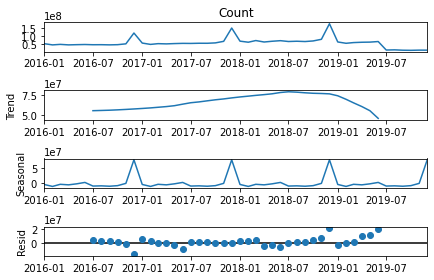

In [88]:
result = seasonal_decompose(transactions['Count'], model='add')  # model='mul' also works
result.plot();

### Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders
This may take awhile as there are a lot more combinations to evaluate.

In [127]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(transactions['Count'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   48
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood                -883.609
Date:                              Mon, 18 Jan 2021   AIC                           1775.219
Time:                                      14:47:34   BIC                           1782.703
Sample:                                           0   HQIC                          1778.047
                                               - 48                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.404e+07   1.33e-09   2.55e+16      0.000     3.4e+07     3.4e+07
ar.L1          0.4368      0.089      4.933      0.000       0.263       0.610
ma.S.L12       0.4330      0.137      3.159      0.002       0.164       0.702
sigma2      6.788e+14    3.7e-17   1.83e+31      0.000    6.79e+14    6.79e+14
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                37.44
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               3.96   Skew:                             1.04
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.49e+47. Standard errors may be unstable.
"""

Excellent! This provides an ARIMA Order of (0,1,3) combined with a seasonal order of (1,0,1,12) Now let's train & test the SARIMA(0,1,3)(1,0,1,12) model, evaluate it, then produce a forecast of future values.
### Split the data into train/test sets

In [91]:
len(df)

1285

In [94]:
train = df.iloc[:920]
test = df.iloc[920:]

### Fit a SARIMA(0,1,3)(1,0,1,12) Model

In [95]:
model = SARIMAX(train['Count'],order=(0,1,3),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Count   No. Observations:                  920
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood              -13332.970
Date:                              Mon, 18 Jan 2021   AIC                          26677.940
Time:                                      13:44:21   BIC                          26706.880
Sample:                                           0   HQIC                         26688.985
                                              - 920                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0039      0.012      0.324      0.746      -0.020       0.028
ma.L2         -0.2887      0.011    -25.904      0.000      -0.311      -0.267
ma.L3         -0.1237      0.015     -8.217      0.000      -0.153      -0.094
ar.S.L12       0.3511      0.755      0.465      0.642      -1.129       1.831
ma.S.L12      -0.4168      0.747     -0.558      0.577      -1.880       1.046
sigma2      2.414e+11   2.67e-11   9.03e+21      0.000    2.41e+11    2.41e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            250642.22
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               7.72   Skew:                            -5.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        83.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.69e+36. Standard errors may be unstable.
"""

In [99]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Predictions')

In [113]:
predictions

920     1.793295e+06
921     1.867641e+06
922     1.891211e+06
923     1.925489e+06
924     1.962324e+06
            ...     
1280    1.963866e+06
1281    1.963866e+06
1282    1.963866e+06
1283    1.963866e+06
1284    1.963866e+06
Name: SARIMA(0,1,3)(1,0,1,12) Predictions, Length: 365, dtype: float64

In [116]:
test['Count'][920+1]

1964257

In [106]:
len(predictions)

365

In [117]:
predictions[920+1]

1867641.1620388306

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing <tt>typ='levels'</tt> predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

In [126]:
# Compare predictions to expected values
for i in range(920+len(predictions)):
    print(f"predicted={predictions[920+i]}, expected={test['Count'][920+i]}")

predicted=1793295.1196585621, expected=1888234
predicted=1867641.1620388306, expected=1964257
predicted=1891211.2445576307, expected=2145996
predicted=1925488.9710714358, expected=2188969
predicted=1962324.3922259714, expected=2442074
predicted=1956543.2154933622, expected=2171837
predicted=1937852.337271131, expected=1707227
predicted=1963095.8412994198, expected=2018411
predicted=1947592.7512645498, expected=2128080
predicted=1934379.1543188775, expected=2010684
predicted=1940649.8526796778, expected=2197057
predicted=1958409.349476892, expected=2329795
predicted=1954432.2882804275, expected=2230809
predicted=1942920.8634086736, expected=2038390
predicted=1938359.4586781762, expected=1881807
predicted=1950393.2563333688, expected=1878605
predicted=1963324.9775937905, expected=2026714
predicted=1961295.3940103778, expected=2099344
predicted=1954733.633082809, expected=2184490
predicted=1963595.8083341965, expected=2165404
predicted=1958153.1764130064, expected=1830806
predicted=195351

KeyError: 1285

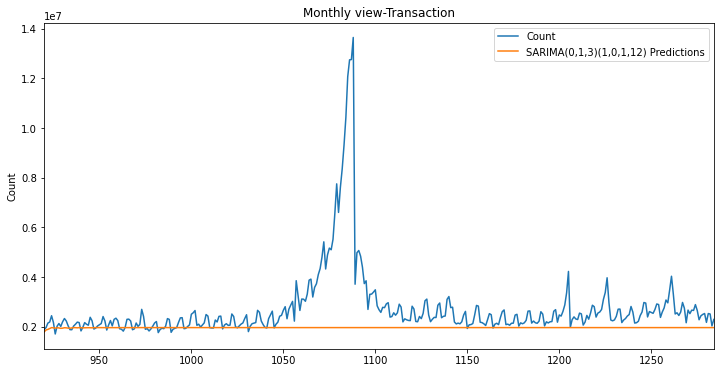

In [142]:
# Plot predictions against known values
title = 'Monthly view-Transaction'
ylabel='Count'
xlabel=''

ax = test['Count'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [152]:
df.head()

,Count
Date,
2016-01-01,2093576
2016-02-01,2397260
2016-03-01,2173039
2016-04-01,2051240
2016-05-01,1954117


### Evaluate the Model

In [153]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Count'], predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) MSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) MSE Error: 2.72483081e+12


In [155]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Count'], predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) RMSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) RMSE Error: 1650706.155


In [166]:
len(transactions)

48

These are outstanding results!
### Retrain the model on the full data, and forecast the future

In [185]:
model = SARIMAX(transactions['Count'],order=(0,1,3),seasonal_order=(1,0,1,12))
results = model.fit()
fcast = results.predict(len(transactions),len(transactions)+11,type='levels').rename('SARIMA(0,1,3)(1,0,1,12) Forecast')

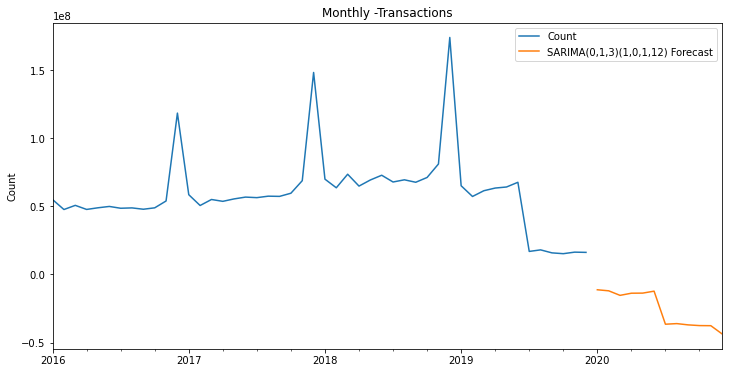

In [186]:
# Plot predictions against known values
title = 'Monthly -Transactions'
ylabel='Count'
xlabel=''

ax =  transactions['Count'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [192]:
fcast['2020-01-01']

-11244071.392684063